# Summary: 

This notebook is for analyzing experiment results for synthetic problems using the new code (BopeExperiment class).

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import pickle
import re
import warnings
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import torch 

warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Choose a set of problem setups and experiment trial indices

In [3]:
# setup = {
#     "rank_l": [1,2,4,8],
#     "outcome_dim_l": [50],
#     "alpha_l": [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
#     "noise_l": [0.05, 0.1, 0.5],
#     "trial_range": range(21)
# }

# setup = {
#     "rank_l": [1,2,4],
#     "outcome_dim_l": [50],
#     "alpha_l": [0.0, 0.5, 1.0],
#     "noise_l": [0.1],
#     "trial_range": range(31,51)
# }

# setup = {
#     "rank_l": [1,2,4],
#     "outcome_dim_l": [50],
#     "alpha_l": [0.0, 0.5, 1.0],
#     "noise_l": [0.0],
#     "trial_range": range(51, 71)
# }

# setup = {
#     "rank_l": [1,4,8],
#     "outcome_dim_l": [50],
#     "alpha_l": [0.0, 0.5, 1.0],
#     "noise_l": [0.01],
#     "trial_range": range(71, 90)
# }


setup = {
    "input_dim": 5,
    "rank_l": [1,3,5],
    "outcome_dim_l": [50],
    "alpha_l": [0.0, 0.5, 1.0],
    "noise_l": [0.01],
    "trial_range": range(21)
}

In [4]:
problems = [f"rank_{rank}_linear_{setup['input_dim']}_{outcome_dim}_{alpha}_{noise}" for rank in setup["rank_l"] \
    for outcome_dim in setup["outcome_dim_l"]\
        for alpha in setup["alpha_l"] \
            for noise in setup["noise_l"]]

In [5]:
# problems = "rank_1_linear_1_50_1.0_0.1"
outputs = defaultdict(lambda: defaultdict(dict))

for problem in problems:

    results_folder = f'/home/yz685/low_rank_BOPE/experiments/synthetic/{problem}/'

    for trial in setup["trial_range"]:

        try:

            outputs[problem]['exp_candidate_results'][trial] = \
                list(vv for v in torch.load(results_folder + f'final_candidate_results_trial={trial}.th').values() for vv in v.values())
            
            outputs[problem]['within_session_results'][trial] = \
                list(itertools.chain.from_iterable(vv for v in torch.load(results_folder + f'PE_session_results_trial={trial}.th').values() for vv in v.values()))
        
            outputs[problem]['outcome_model_fitting_results'][trial] = \
                torch.load(results_folder + f'outcome_model_fitting_results_trial={trial}.th')

        except:
            print(f"{problem} Trial {trial} not finished yet, skipping for now")
            continue

rank_1_linear_5_50_0.0_0.01 Trial 0 not finished yet, skipping for now
rank_1_linear_5_50_0.5_0.01 Trial 0 not finished yet, skipping for now
rank_1_linear_5_50_1.0_0.01 Trial 0 not finished yet, skipping for now
rank_3_linear_5_50_0.0_0.01 Trial 0 not finished yet, skipping for now
rank_3_linear_5_50_0.5_0.01 Trial 0 not finished yet, skipping for now
rank_3_linear_5_50_1.0_0.01 Trial 0 not finished yet, skipping for now
rank_5_linear_5_50_0.0_0.01 Trial 0 not finished yet, skipping for now
rank_5_linear_5_50_0.0_0.01 Trial 15 not finished yet, skipping for now
rank_5_linear_5_50_0.5_0.01 Trial 0 not finished yet, skipping for now
rank_5_linear_5_50_0.5_0.01 Trial 15 not finished yet, skipping for now
rank_5_linear_5_50_1.0_0.01 Trial 0 not finished yet, skipping for now
rank_5_linear_5_50_1.0_0.01 Trial 15 not finished yet, skipping for now
rank_5_linear_5_50_1.0_0.01 Trial 18 not finished yet, skipping for now


In [6]:
outputs.keys()

dict_keys(['rank_1_linear_5_50_0.0_0.01', 'rank_1_linear_5_50_0.5_0.01', 'rank_1_linear_5_50_1.0_0.01', 'rank_3_linear_5_50_0.0_0.01', 'rank_3_linear_5_50_0.5_0.01', 'rank_3_linear_5_50_1.0_0.01', 'rank_5_linear_5_50_0.0_0.01', 'rank_5_linear_5_50_0.5_0.01', 'rank_5_linear_5_50_1.0_0.01'])

In [7]:
colors_dict = {
    "pca": "tab:red", 
    "pcr": "tab:cyan", 
    "st": "tab:blue", 
    "true_proj": "tab:pink",
    "random_linear_proj": "tab:green", 
    "random_subset": "tab:orange", 
    "mtgp": "tab:purple", 
    "lmc1": "tab:pink",
    "lmc2": "tab:brown"
}
linestyle_dict = {"Random-f": "--", "EUBO-zeta": "-"}
marker_dict = {"$EUBO-\zeta$": "o", "True Utility": "s", "Random-f": "^"}
labels_dict = {
    "st": "Indep", "pca": "PCA", "pcr": "PCR", "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2",
    "true_proj": "True-proj"
}

In [6]:
def plot_result_metric(problem, metric, plot_title):

    f, axs = plt.subplots(1, 1, figsize=(8, 6))

    # input_dim, outcome_dim = problems[problem]

    _, rank, _, input_dim, outcome_dim, alpha, noise_std = problem.split("_")

    available_trials = outputs[problem]["exp_candidate_results"].keys()

    exp_candidate_results = [res for i in available_trials for res in outputs[problem]["exp_candidate_results"][i]]

    exp_candidate_results_random = []
    exp_candidate_results_nonrandom = []

    for res in exp_candidate_results:
        if res["strategy"] == "Random Experiment":
            exp_candidate_results_random.append(res)
        else:
            exp_candidate_results_nonrandom.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
    exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    exp_df["strategy"] = pd.Categorical(
        exp_df["strategy"],
        ["True Utility", "$EUBO-\zeta$", "Random-f"],
    )

    exp_df = (
        exp_df.groupby(["method", "strategy"], sort=False)
        .agg({metric: ["mean", "sem"]})
        # .agg({"time_consumed": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in exp_df.groupby(["method", "strategy"]):

        if group["method"].values[0] == 'mtgp':
            continue

        if group["strategy"].values[0] in ["$EUBO-\zeta$", "Random-f"]:

            if not group["mean"].isna().all():
                axs.errorbar(
                    x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
                    y=group["mean"],
                    yerr=1.96 * group["sem"],
                    fmt=marker_dict[name[1]],
                    markersize=8,
                    label=labels_dict[group["method"].values[0]] + "_" + group["strategy"].values[0],
                    linewidth=1.5,
                    capsize=3,
                    color=colors_dict[name[0]],
                    # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
                )

    axs.set_title(
        f"{problem}\n d={input_dim}, k={outcome_dim}", fontsize=16
    )
    axs.set_xticks([])

    axs.legend(bbox_to_anchor=(-0.05, -0.2), loc="lower left", ncol=3, fontsize=12)
    axs.set_ylabel(plot_title)


In [9]:
def plot_result_metric_multiple(problem_l, metric, plot_title):

    f, axs = plt.subplots(1, len(problem_l), figsize=(15, 3))

    for i in range(len(problem_l)):
        problem = problem_l[i]
        _, rank, _, input_dim, outcome_dim, alpha, noise_std = problem.split("_")

        available_trials = outputs[problem]["exp_candidate_results"].keys()

        exp_candidate_results = [res for i in available_trials for res in outputs[problem]["exp_candidate_results"][i]]

        exp_candidate_results_random = []
        exp_candidate_results_nonrandom = []

        for res in exp_candidate_results:
            if res["strategy"] == "Random Experiment":
                exp_candidate_results_random.append(res)
            else:
                exp_candidate_results_nonrandom.append(res)

        # Prepare the 2nd experimentation batch data for plot
        exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
        exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
        exp_df["strategy"] = pd.Categorical(
            exp_df["strategy"],
            ["True Utility", "$EUBO-\zeta$", "Random-f"],
        )

        exp_df = (
            exp_df.groupby(["method", "strategy"], sort=False)
            .agg({metric: ["mean", "sem"]})
            .droplevel(level=0, axis=1)
            .reset_index()
        )

        for name, group in exp_df.groupby(["method", "strategy"]):

            if group["method"].values[0] == 'mtgp':
                continue

            if group["strategy"].values[0] in ["$EUBO-\zeta$", "Random-f"]:

                if not group["mean"].isna().all():
                    axs[i].errorbar(
                        x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
                        y=group["mean"],
                        yerr=1.96 * group["sem"],
                        fmt=marker_dict[name[1]],
                        markersize=8,
                        label=labels_dict[group["method"].values[0]] + "_" + group["strategy"].values[0],
                        linewidth=1.5,
                        capsize=3,
                        color=colors_dict[name[0]],
                    )

        axs[i].set_title(
            f"{problem}\n d={input_dim}, k={outcome_dim}", fontsize=12.5
        )
        axs[i].set_xticks([])

    axs[0].legend(bbox_to_anchor=(-0.1, -0.2), loc="lower left", ncol=5, fontsize=12)
    axs[0].set_ylabel(plot_title)

# axs.axhline(y=29)


# Plot final candidate quality

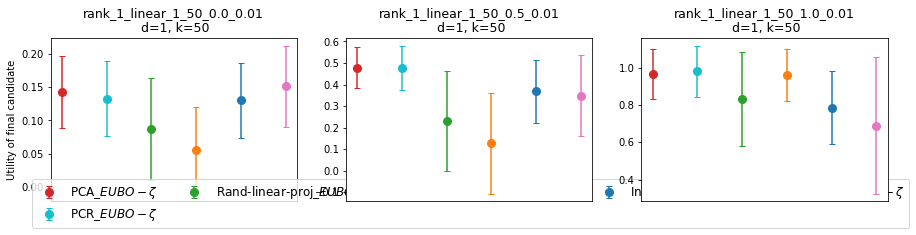

In [31]:
plot_result_metric_multiple(
    problem_l = problems[:3],
    metric = "candidate_util",
    plot_title = "Utility of final candidate"
)

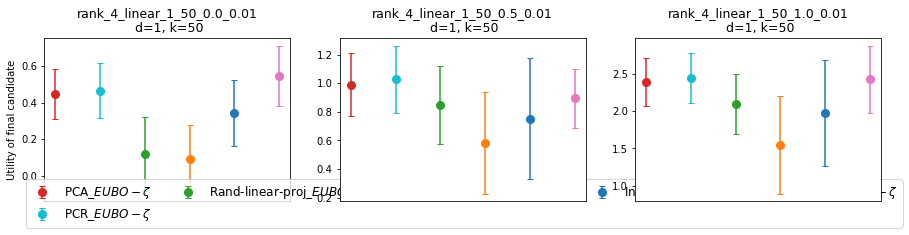

In [32]:
plot_result_metric_multiple(
    problem_l = problems[3:6],
    metric = "candidate_util",
    plot_title = "Utility of final candidate"
)

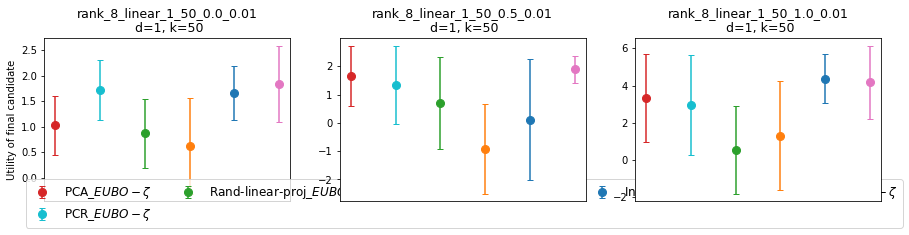

In [33]:
plot_result_metric_multiple(
    problem_l = problems[6:],
    metric = "candidate_util",
    plot_title = "Utility of final candidate"
)

# Time consumed in preference exploration stage

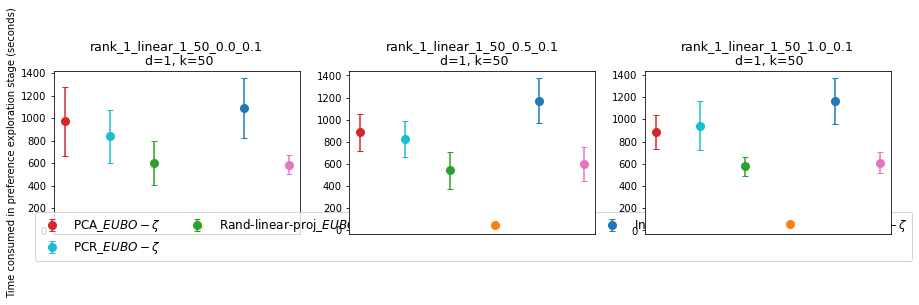

In [15]:
plot_result_metric_multiple(
    problem_l = [
        "rank_1_linear_1_50_0.0_0.1",
        "rank_1_linear_1_50_0.5_0.1",
        "rank_1_linear_1_50_1.0_0.1"
    ],
    metric = "PE_time",
    plot_title = "Time consumed in preference exploration stage (seconds)"
)

# Final utility model accuracy

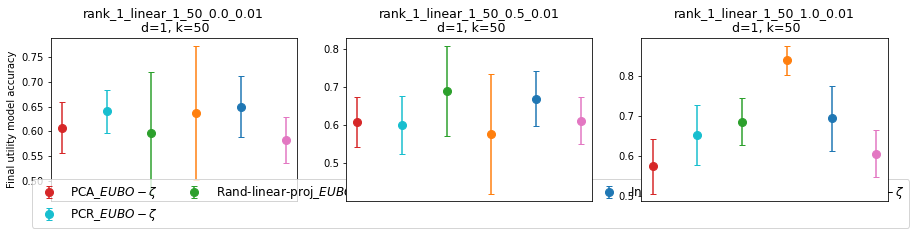

In [101]:
plot_result_metric_multiple(
    problem_l = problems[:3],
    metric = "util_model_acc",
    plot_title = "Final utility model accuracy"
)

# Plot quality of candidate over BOPE comparisons

In [17]:
from matplotlib.ticker import MaxNLocator

def plot_candidate_over_comps(problem, pe_strategy, methods = ["st", "pca", "random_linear_proj", "random_subset", "mtgp"]):

    f, axs = plt.subplots(1, 1, figsize=(8, 6))

    x_jitter_dict = {
        "pca": 0.1, 
        "st": 0, 
        "random_linear_proj": 0.2, "random_subset": 0.3, 
        "mtgp": 0.75, "lmc1": 0.4, "lmc2": 0.5, 
        "pcr": 0.05, "true_proj": 0.15}
    
    _, rank, _, input_dim, outcome_dim, alpha, noise = problem.split('_')
    
    within_session_results = [res 
                              for i in outputs[problem]['within_session_results'].keys() 
                              for res in outputs[problem]["within_session_results"][i]]

    within_df = pd.DataFrame(within_session_results)

    within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    within_df = (
        within_df.groupby(["n_comps", "method", "pe_strategy"])
        .agg({"util": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in within_df.groupby(["method", "pe_strategy"]):
        if name[1] == pe_strategy:
            if name[0] in methods:

                jitter = x_jitter_dict[group["method"].values[0]]
                x_jittered = [x_ + jitter for x_ in group["n_comps"].values]
                print(name[0], name[1], 'n_comps: ', group["n_comps"].values)

                axs.errorbar(
                    x=x_jittered,
                    y=group["mean"].values,
                    yerr=1.96 * group["sem"],
                    # label="_".join(name),
                    label=labels_dict[name[0]],
                    linewidth=1.5,
                    capsize=3,
                    alpha=0.6,
                    color=colors_dict[name[0]],
                )

                # ax1.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))

                axs.set_xlabel("Number of comparisons")
                axs.set_title(
                    f"d={input_dim}, k={outcome_dim}, rank={rank}, alpha={alpha}, noise={noise}", fontsize=16
                )
                axs.xaxis.set_major_locator(MaxNLocator(integer=True))

    axs.set_ylabel("True utility of estimated \n utility-maximizing design")
    axs.legend(loc="lower left", ncol=5, fontsize=15)

In [8]:
def plot_candidate_over_comps_multiple(
    problem_l, pe_strategy, 
    methods = ["st", "pca", "random_linear_proj", "random_subset", "mtgp"]):

    f, axs = plt.subplots(1, len(problem_l), figsize=(15, 3))

    x_jitter_dict = {"pca": 0.1, "st": 0, "random_linear_proj": 0.2, "random_subset": 0.3, "mtgp": 0.75, "lmc1": 0.4, "lmc2": 0.5, "pcr": 0.05}

    for j in range(len(problem_l)):
        problem = problem_l[j]

        _, rank, _, input_dim, outcome_dim, alpha, noise = problem.split('_')

        within_session_results = [res 
                                for i in outputs[problem]['within_session_results'].keys() 
                                for res in outputs[problem]["within_session_results"][i]]

        within_df = pd.DataFrame(within_session_results)

        within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
        within_df = (
            within_df.groupby(["n_comps", "method", "pe_strategy"])
            .agg({"util": ["mean", "sem"]})
            .droplevel(level=0, axis=1)
            .reset_index()
        )

        for name, group in within_df.groupby(["method", "pe_strategy"]):
            if name[1] == pe_strategy:
                if name[0] in methods:

                    jitter = x_jitter_dict[group["method"].values[0]]
                    x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

                    axs[j].errorbar(
                        x=x_jittered,
                        y=group["mean"].values,
                        # yerr=1.96 * group["sem"],
                        yerr = group["sem"],
                        # label="_".join(name),
                        label=labels_dict[name[0]],
                        linewidth=1.5,
                        capsize=3,
                        alpha=0.6,
                        color=colors_dict[name[0]],
                    )

                    axs[j].set_xlabel("Number of comparisons", fontsize=12)
                    axs[j].set_title(
                        f"{problem}\n d={input_dim}, k={outcome_dim}", fontsize=12.5
                    )

    axs[0].set_ylabel("True utility of estimated \n utility-maximizing design", fontsize=12)
    axs[0].legend(bbox_to_anchor=(-0.05, -0.4), loc="lower left", ncol=5, fontsize=12)
    # axs[1].legend(fontsize=11.5)

In [27]:
# NOTE: it is not a bug that some methods have a long sequence of n_comps on the x-axis
# with step size smaller than 3. 
# This is because optimizing EUBO frequently fails, in which case we gather <3 comparisons 
# in the current PE step. Thus, for different trials,
# n_comps can contain different numbers.
# Then, when we group by n_comps in within_df, it keeps all the different n_comps values.

# TODO: why is EUBO failing so frequently?

In [15]:
outputs[problems[0]]

defaultdict(dict, {})

In [ ]:
for problem in problems:
    try:
        plot_candidate_over_comps(problem, '$EUBO-\zeta$', methods = ["st", "pca", "true_proj"])
        plt.savefig(f"/home/yz685/low_rank_BOPE/plots/synthetic/{problem}_candidate_progression.pdf", bbox_inches = "tight")
        plt.close();
    except KeyError as e:
        print(problem, e)

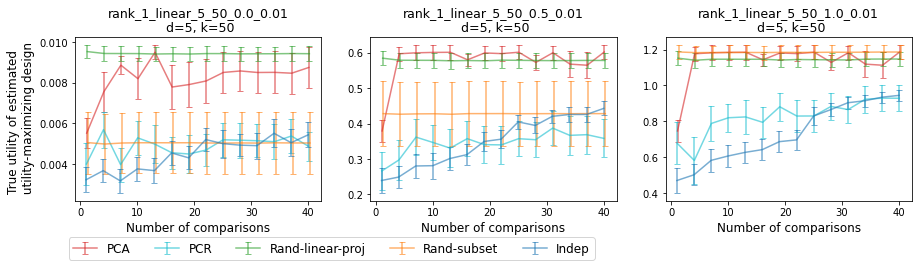

In [10]:
plot_candidate_over_comps_multiple(
    problem_l = problems[:3], 
    pe_strategy='$EUBO-\zeta$', 
    methods = [
        "st", "pca", 
        "pcr", 
        "random_linear_proj", "random_subset"
    ]
)


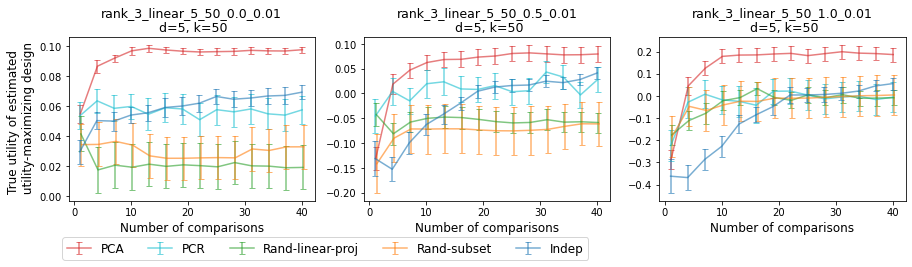

In [14]:
plot_candidate_over_comps_multiple(
    problem_l = problems[3:6], 
    pe_strategy='$EUBO-\zeta$', 
    methods = ["st", "pca", 
        "pcr",
        "random_linear_proj", "random_subset"
    ]
)

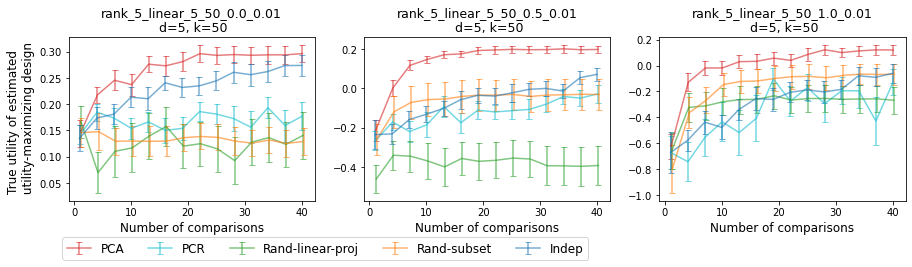

In [13]:
plot_candidate_over_comps_multiple(
    problem_l = problems[6:], 
    pe_strategy='$EUBO-\zeta$', 
    methods = [
        "st", "pca", 
        "pcr", 
        "random_linear_proj", "random_subset",
    ]
)

pca $EUBO-\zeta$ n_comps:  [ 1  2  3  4  5  6  7  8  9 10 11 13]
st $EUBO-\zeta$ n_comps:  [ 1  4  7 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]
true_proj $EUBO-\zeta$ n_comps:  [ 1  2  3  4  5  6  7  8  9 10 11 12]


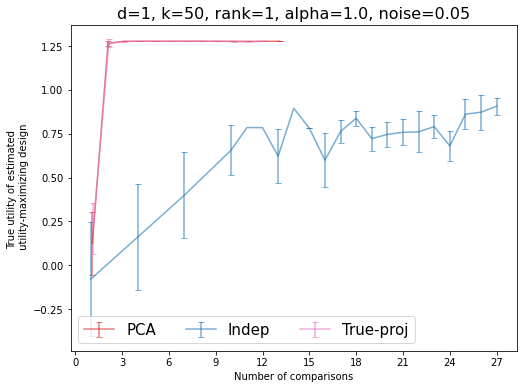

In [52]:
plot_candidate_over_comps('rank_1_linear_1_50_1.0_0.05', '$EUBO-\zeta$', methods = ["st", "pca", "true_proj", "random_linear_proj", "random_subset"])
# plt.savefig(f'BOPE_real_cand_progression.pdf', bbox_inches = "tight")

pca $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]
random_linear_proj $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]
random_subset $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]
st $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]
true_proj $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]


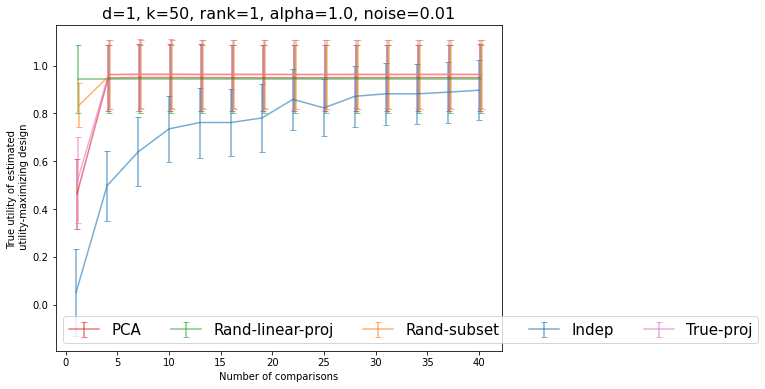

In [103]:
plot_candidate_over_comps("rank_1_linear_1_50_1.0_0.01", '$EUBO-\zeta$', methods = ["st", "pca", "true_proj", "random_linear_proj", "random_subset"])


pca $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]
random_linear_proj $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]
random_subset $EUBO-\zeta$ n_comps:  [1]
st $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]
true_proj $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 16 19 22 25 28 31 34 37 40]


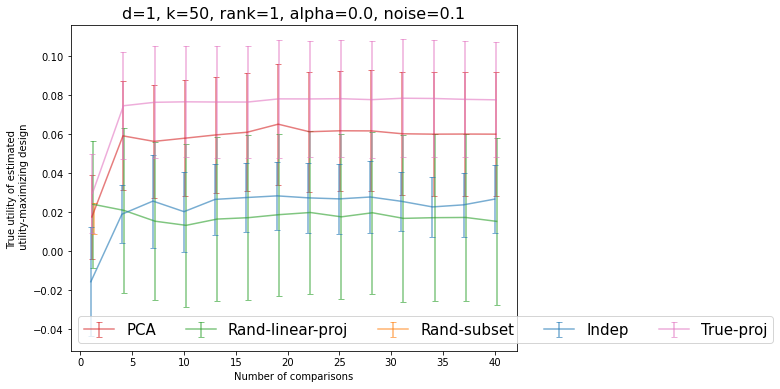

In [38]:
plot_candidate_over_comps("rank_1_linear_1_50_0.0_0.1", '$EUBO-\zeta$', methods = ["st", "pca", "true_proj", "random_linear_proj", "random_subset"])


pca $EUBO-\zeta$ n_comps:  [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 27 28 31]
st $EUBO-\zeta$ n_comps:  [ 1  4  5  6  7  8  9 10 11 12 14 15 16 17 18 21]
true_proj $EUBO-\zeta$ n_comps:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 20 21 23 24 26 27 29]


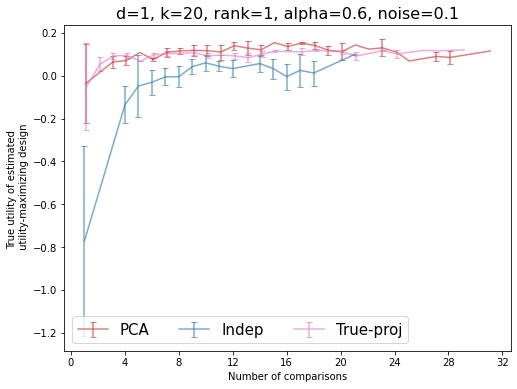

In [19]:
plot_candidate_over_comps("rank_1_linear_1_20_0.6_0.1", '$EUBO-\zeta$', methods = ["st", "pca", "true_proj"])


pca $EUBO-\zeta$ n_comps:  [ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 25 26 29
 32 35]
pcr $EUBO-\zeta$ n_comps:  [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 25 26 27 28
 29 31 32 34 35 38]
st $EUBO-\zeta$ n_comps:  [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
true_proj $EUBO-\zeta$ n_comps:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 33]


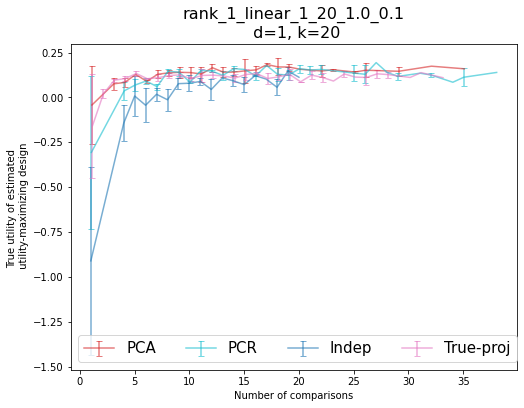

In [13]:
plot_candidate_over_comps("rank_1_linear_1_20_1.0_0.1", '$EUBO-\zeta$', methods = ["st", "pca", "pcr", "true_proj"])


pca $EUBO-\zeta$ n_comps:  [ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 35 36]
pcr $EUBO-\zeta$ n_comps:  [ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 28 29 31 32 34 35]
st $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 15 16 18 19 20 21 22 24 25 26 27 28 29 30 31 33 34 35 37
 40]
true_proj $EUBO-\zeta$ n_comps:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 28 29 32 35 38]


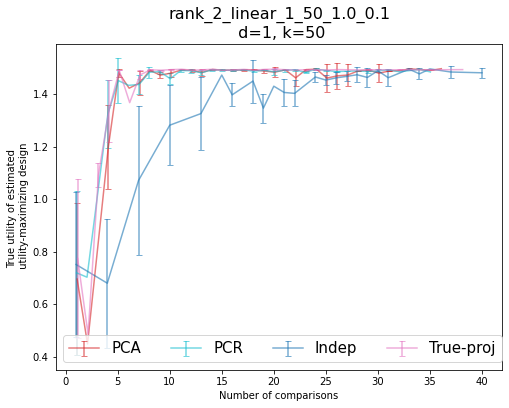

In [17]:
plot_candidate_over_comps("rank_2_linear_1_50_1.0_0.1", '$EUBO-\zeta$', methods = ["st", "pca", "pcr", "true_proj"])


pca $EUBO-\zeta$ n_comps:  [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 33 36]
pcr $EUBO-\zeta$ n_comps:  [ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 31]
st $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 15 16 18 19 20 21 22 24 25 26 27 28 29 30 31 33 34 35 36
 37 39 40]
true_proj $EUBO-\zeta$ n_comps:  [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 28 29 31 32 33 35 38]


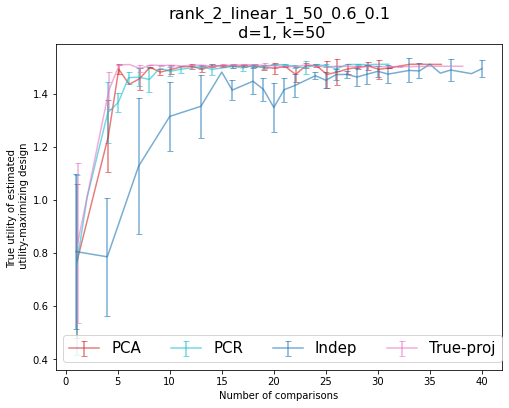

In [18]:
plot_candidate_over_comps("rank_2_linear_1_50_0.6_0.1", '$EUBO-\zeta$', methods = ["st", "pca", "pcr", "true_proj"])


pca $EUBO-\zeta$ n_comps:  [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 36]
pcr $EUBO-\zeta$ n_comps:  [ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 35 38]
st $EUBO-\zeta$ n_comps:  [ 1  4  7 10 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37]
true_proj $EUBO-\zeta$ n_comps:  [ 1  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 32 35]


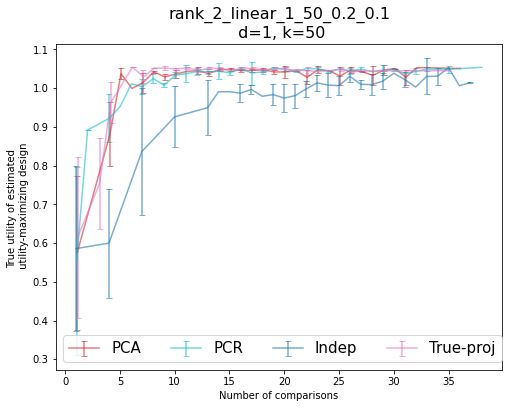

In [19]:
plot_candidate_over_comps("rank_2_linear_1_50_0.2_0.1", '$EUBO-\zeta$', methods = ["st", "pca", "pcr", "true_proj"])


In [19]:
pd.concat({k: pd.DataFrame(v) for k, v in outputs["rank_1_linear_1_50_0.5_0.0"]["outcome_model_fitting_results"].items()}, axis=0)

pca        st           pcr  \
51 model_fitting_time      1.332727e+00  2.532721  7.592644e+00   
   rel_mse                 6.511464e-02  0.048844  1.211975e-01   
   num_pca_axes            1.000000e+00       NaN           NaN   
   max_util_error          5.551115e-16       NaN  4.440892e-16   
   max_outcome_error       7.143062e-16       NaN  3.189505e-16   
...                                 ...       ...           ...   
70 rel_mse                 6.511464e-02  0.048844  1.207433e-01   
   num_pca_axes            1.000000e+00       NaN           NaN   
   max_util_error          2.220446e-16       NaN  2.220446e-16   
   max_outcome_error       4.277080e-16       NaN  4.708210e-16   
   num_axes_overlap_w_pca           NaN       NaN  1.000000e+00   

                           random_linear_proj  random_subset  true_proj  
51 model_fitting_time                0.751311       0.990116   1.592844  
   rel_mse                           0.962942       0.982177   0.065115  
   num_pca_axes                           NaN            NaN        NaN  
   max_util_error                    0.738480            NaN        NaN  
   max_outcome_error                 1.250519            NaN        NaN  
...                                       ...            ...        ...  
70 rel_mse                           0.966969       0.986396   0.065115  
   num_pca_axes                           NaN            NaN        NaN  
   max_util_error                    0.548613            NaN        NaN  
   max_outcome_error                 1.253382            NaN        NaN  
   num_axes_overlap_w_pca                 NaN            NaN        NaN  

[120 rows x 6 columns]

In [84]:
def plot_outcome_model_metric_multiple(problem_l, methods, metric, plot_title):

    f, axs = plt.subplots(1, len(problem_l), figsize=(15, 3))

    for i in range(len(problem_l)):
        problem = problem_l[i]
        _, rank, _, input_dim, outcome_dim, alpha, noise = problem.split('_')
        df = pd.concat(
            [pd.DataFrame(v) for _, v in outputs[problem]["outcome_model_fitting_results"].items()], 
            axis=0)
        df.index.name="metric"

        for method in methods:
            df_method = df.groupby(["metric"]).agg({method: ["mean", "sem"]})
            df_method_dict = df_method.to_dict()
            mean, sem = df_method_dict[(method, "mean")][metric], df_method_dict[(method, "sem")][metric]

            axs[i].errorbar(
                x = method,
                y = mean,
                yerr = sem,
                fmt="o",
                markersize=8,
                label=labels_dict[method],
                linewidth=1.5,
                capsize=3,
                color=colors_dict[method],
            )
            axs[i].set_title(
                    rf"$d$={input_dim}, $k$={outcome_dim}, $m$={rank}, $\alpha$={alpha}, $\sigma$={noise}", fontsize=16
                )
            axs[i].tick_params(axis='x', which='major', labelsize=15)

    # axs[0].legend(bbox_to_anchor=(-0.1, -0.2), loc="lower left", ncol=5, fontsize=12)
    axs[0].legend(fontsize=12)
    axs[0].set_ylabel(plot_title)


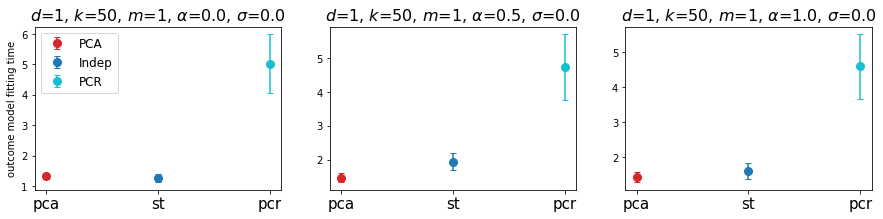

In [85]:

plot_outcome_model_metric_multiple(
    problem_l = [
        "rank_1_linear_1_50_0.0_0.0", 
        "rank_1_linear_1_50_0.5_0.0", 
        "rank_1_linear_1_50_1.0_0.0"], 
    methods = ["pca", "st", "pcr"], 
    metric = "model_fitting_time", 
    plot_title = "outcome model fitting time"
)

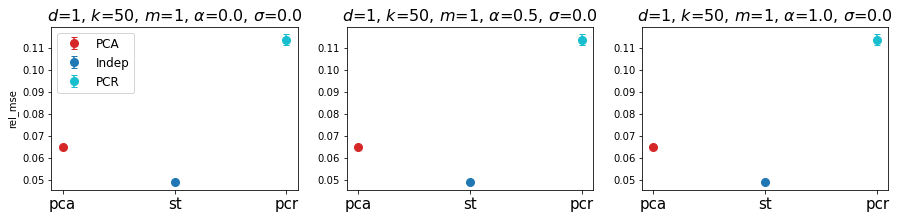

In [87]:

plot_outcome_model_metric_multiple(
    problem_l = [
        "rank_1_linear_1_50_0.0_0.0", 
        "rank_1_linear_1_50_0.5_0.0", 
        "rank_1_linear_1_50_1.0_0.0"], 
    methods = ["pca", "st", "pcr"], 
    metric = "rel_mse", 
    plot_title = "rel_mse"
)

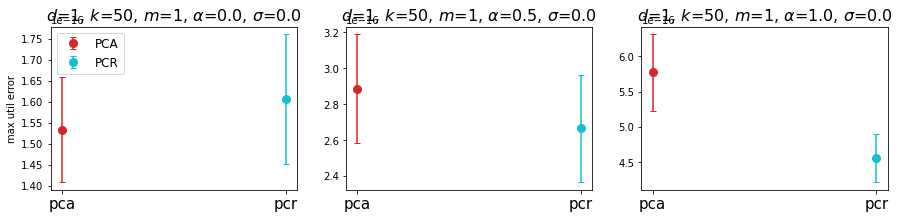

In [90]:
plot_outcome_model_metric_multiple(
    problem_l = [
        "rank_1_linear_1_50_0.0_0.0", 
        "rank_1_linear_1_50_0.5_0.0", 
        "rank_1_linear_1_50_1.0_0.0"], 
    methods = ["pca", "pcr"], 
    metric = "max_util_error", 
    plot_title = "max util error"
)

# Outcome model fitting time

In [ ]:
# TODO

# Outcome model accuracy

In [ ]:
# TODO

# Other diagnostics

e.g., subspace recovery diagnostics, number of principal axes, number of axes that PCR selects that overlap with PCA axes, ...

In [ ]:
# TODO

In [ ]:
plot_outcome_metric_multiple(
    problem_l = [
        "rank_1_linear_1_50_0.0_0.0", 
        "rank_1_linear_1_50_0.5_0.0", 
        "rank_1_linear_1_50_1.0_0.0"], 
    methods = ["pca", "st", "pcr"], 
    metric = "model_fitting_time", 
    plot_title = "rel_mse"
)

In [31]:
test_df.groupby(["metric"]).agg({"pcr": ["mean", "sem"]})

pcr              
                                mean           sem
metric                                            
max_outcome_error       4.846870e-16  4.822527e-17
max_util_error          2.664535e-16  3.002900e-17
model_fitting_time      4.746197e+00  9.680341e-01
num_axes_overlap_w_pca  1.000000e+00  0.000000e+00
num_pca_axes                     NaN           NaN
rel_mse                 1.136260e-01  2.582476e-03

In [32]:
test_df.groupby(["metric"]).agg({"st": ["mean", "sem"]})

st              
                            mean           sem
metric                                        
max_outcome_error            NaN           NaN
max_util_error               NaN           NaN
model_fitting_time      1.940375  2.516172e-01
num_axes_overlap_w_pca       NaN           NaN
num_pca_axes                 NaN           NaN
rel_mse                 0.048844  2.098233e-10

In [20]:
outputs["rank_1_linear_1_50_0.5_0.0"]["outcome_model_fitting_results"]

{51: defaultdict(dict,
             {'pca': {'model_fitting_time': 1.3327274322509766,
               'rel_mse': 0.06511463664799826,
               'num_pca_axes': 1,
               'max_util_error': 5.551115123125783e-16,
               'max_outcome_error': 7.14306169143021e-16},
              'st': {'model_fitting_time': 2.5327212810516357,
               'rel_mse': 0.04884413111585766},
              'pcr': {'model_fitting_time': 7.592643737792969,
               'rel_mse': 0.12119747381447173,
               'num_axes_overlap_w_pca': 1,
               'max_util_error': 4.440892098500626e-16,
               'max_outcome_error': 3.1895052140082773e-16},
              'random_linear_proj': {'model_fitting_time': 0.7513113021850586,
               'rel_mse': 0.9629420173904162,
               'max_util_error': 0.7384800535785456,
               'max_outcome_error': 1.2505192965098235},
              'random_subset': {'model_fitting_time': 0.9901158809661865,
               'rel_mse': 

# Outcome model fitting time

In [ ]:
# TODO

# Outcome model accuracy

In [ ]:
# TODO

# Other diagnostics

e.g., subspace recovery diagnostics, number of principal axes, number of axes that PCR selects that overlap with PCA axes, ...

In [ ]:
# TODO

# please ignore below

# 3. Plot outcome and preference prediction accuracy

The goal is to understand the performance at intermediate steps within the BOPE procedure. This helps us understand the different methods better (why they are good / bad)

Text(0, 0.5, 'Preference model accuracy')

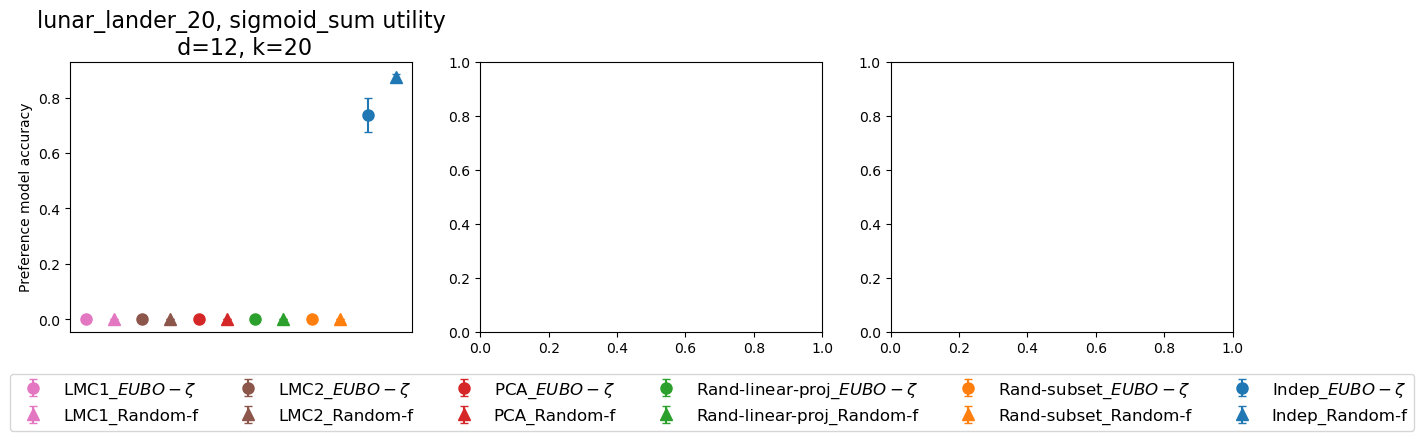

In [10]:
f, axs = plt.subplots(1, 3, figsize=(15, 3.5))
labels_dict = {
    "st": "Indep", "pca": "PCA", "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2"
    }
    
for i in range(len(problem_names)):

    problem = problem_names[i]

    every_n_comps = BASE_CONFIG["every_n_comps"]
    n_check_post_mean = BASE_CONFIG["n_check_post_mean"]
    problem_name = 'lunar_lander_20'
    util_func_name = 'sigmoid_sum'
    input_dim = 12
    outcome_dim = problem # TODO: clean this up

    exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["exp_candidate_results"]]

    exp_candidate_results_random = []
    exp_candidate_results_nonrandom = []

    for res in exp_candidate_results:
        if res["strategy"] == "Random Experiment":
            exp_candidate_results_random.append(res)
        else:
            exp_candidate_results_nonrandom.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
    exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    exp_df["strategy"] = pd.Categorical(
        # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
        exp_df["strategy"],
        ["True Utility", "$EUBO-\zeta$", "Random-f"],
    )
    # exp_df.reindex(['st', 'pca', 'random_linear_proj'], level='method')

    exp_df = (
        exp_df.groupby(["method", "strategy"], sort=False)
        # .agg({"candidate_util": ["mean", "sem"]})
        .agg({"pref_model_acc": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in exp_df.groupby(["method", "strategy"]):

        if group["method"].values[0] == 'mtgp':
            continue

        if group["strategy"].values[0] in ["$EUBO-\zeta$", "Random-f"]:

            axs[i].errorbar(
                x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
                y=group["mean"],
                yerr=1.96 * group["sem"],
                fmt=marker_dict[name[1]],
                markersize=8,
                label=labels_dict[group["method"].values[0]] + "_" + group["strategy"].values[0],
                linewidth=1.5,
                capsize=3,
                color=colors_dict[name[0]],
                # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
            )

    # axs[i].set_xlabel("Transform + PE Strategy")
    # plt.ylabel("Utility achieved in the 2nd experiment stage")
    axs[i].set_title(
        f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}", fontsize=16
    )
    # plt.suptitle(
    #     f"\n {1 + every_n_comps * n_check_post_mean} comps, (outcome,augmented)-dim=({outcome_dim},{augmented_dim})",
    #     fontsize=20,
    # )
    axs[i].set_xticks([])

axs[0].legend(bbox_to_anchor=(-0.2, -0.4), loc="lower left", ncol=6, fontsize=12)
axs[0].set_ylabel("Preference model accuracy")

# plt.savefig(f'BOPE_real_EUBO_randomf.pdf', bbox_inches = "tight")

Text(0, 0.5, 'Outcome model mse')

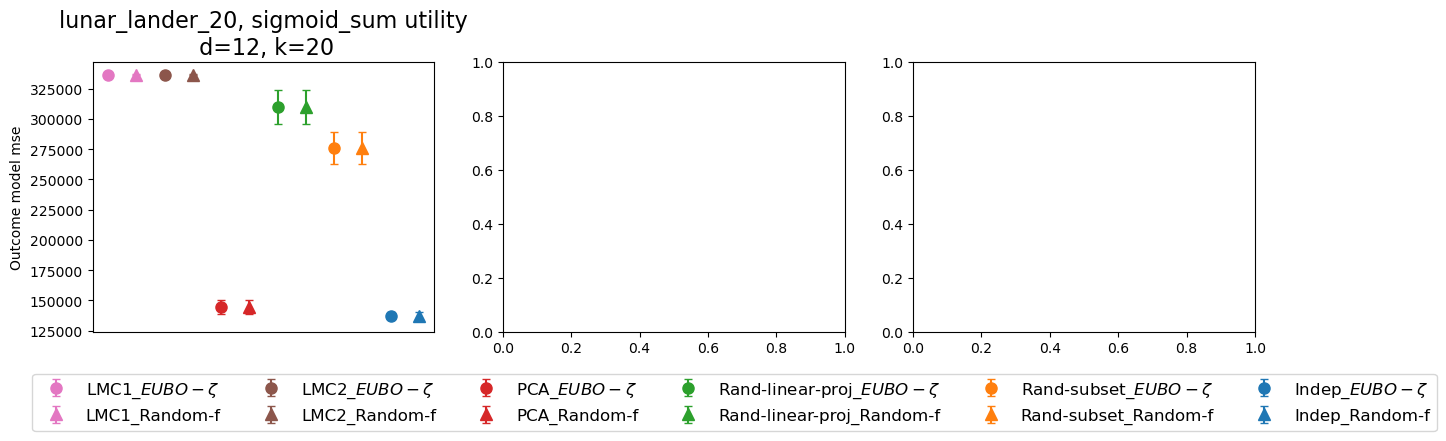

In [11]:
f, axs = plt.subplots(1, 3, figsize=(15, 3.5))
labels_dict = {
    "st": "Indep", "pca": "PCA", "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2"
    }
    
for i in range(len(problem_names)):
    problem = problem_names[i]

    every_n_comps = BASE_CONFIG["every_n_comps"]
    n_check_post_mean = BASE_CONFIG["n_check_post_mean"]
    problem_name = 'lunar_lander_20'
    util_func_name = 'sigmoid_sum'
    input_dim = 12
    outcome_dim = problem # TODO: clean this up


    exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["exp_candidate_results"]]

    exp_candidate_results_random = []
    exp_candidate_results_nonrandom = []

    for res in exp_candidate_results:
        if res["strategy"] == "Random Experiment":
            exp_candidate_results_random.append(res)
        else:
            exp_candidate_results_nonrandom.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
    exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    exp_df["strategy"] = pd.Categorical(
        # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
        exp_df["strategy"],
        ["True Utility", "$EUBO-\zeta$", "Random-f"],
    )
    # exp_df.reindex(['st', 'pca', 'random_linear_proj'], level='method')

    exp_df = (
        exp_df.groupby(["method", "strategy"], sort=False)
        # .agg({"candidate_util": ["mean", "sem"]})
        .agg({"outcome_model_mse": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in exp_df.groupby(["method", "strategy"]):

        if group["method"].values[0] == 'mtgp':
            continue

        if group["strategy"].values[0] in ["$EUBO-\zeta$", "Random-f"]:

            axs[i].errorbar(
                x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
                y=group["mean"],
                yerr=1.96 * group["sem"],
                fmt=marker_dict[name[1]],
                markersize=8,
                label=labels_dict[group["method"].values[0]] + "_" + group["strategy"].values[0],
                linewidth=1.5,
                capsize=3,
                color=colors_dict[name[0]],
                # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
            )

    # axs[i].set_xlabel("Transform + PE Strategy")
    # plt.ylabel("Utility achieved in the 2nd experiment stage")
    axs[i].set_title(
        f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}", fontsize=16
    )
    # plt.suptitle(
    #     f"\n {1 + every_n_comps * n_check_post_mean} comps, (outcome,augmented)-dim=({outcome_dim},{augmented_dim})",
    #     fontsize=20,
    # )
    axs[i].set_xticks([])

axs[0].legend(bbox_to_anchor=(-0.2, -0.4), loc="lower left", ncol=6, fontsize=12)
axs[0].set_ylabel("Outcome model mse")

# plt.savefig(f'BOPE_real_EUBO_randomf.pdf', bbox_inches = "tight")

In [29]:
problem_setup_names = [
    "vehiclesafety_5d3d_piecewiselinear_3c",
    "carcabdesign_7d9d_piecewiselinear_3c",
    "carcabdesign_7d9d_linear_3c",
]
pe_strategy = 'Random-f'
methods = ["st", "pca", "random_linear_proj", "random_subset", "mtgp", "lmc"]

colors_dict = {
    "pca": "tab:red",
    "st": "tab:blue",
    "random_linear_proj": "tab:green",
    "random_subset": "tab:orange",
    "mtgp": "tab:purple",
    "lmc": "tab:pink"
}
x_jitter_dict = {"pca": 0.15, "st": 0, "random_linear_proj": 0.3, "random_subset": 0.45, "mtgp": 0.75, "lmc": 0.6}
labels_dict = {
    "pca": "PCA",
    "st": "Indep",
    "random_linear_proj": "Rand-linear-proj",
    "random_subset": "Rand-subset",
    "mtgp": "MTGP",
    "lmc": "LMC"
}


# outcome_dim = test_configs[config_name]["outcome_dim"]
# latent_dim = test_configs[config_name]["latent_dim"]

for j in range(len(problem_names)):

    problem = problem_names[j]

    print('Problem', problem)

    problem_name = 'lunar_lander_20'
    util_func_name = 'sigmoid_sum'
    input_dim = 12
    outcome_dim = problem

    # exp_candidate_results = [outputs[problem][j]['exp_candidate_results'] for j in range(NUM_TRIALS)]
    exp_candidate_results_l = []
    exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["exp_candidate_results"]]


    for res in exp_candidate_results:
        if res["strategy"] == pe_strategy:
            exp_candidate_results_l.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_l)

    exp_df_time = (
        exp_df.groupby(["method", "strategy"])
        .agg({"time_consumed": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    print('time consumed \n ', exp_df_time)

    exp_df_outcome_mse = (
        exp_df.groupby(["method", "strategy"])
        .agg({"outcome_model_mse": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    print('outcome mse \n ', exp_df_outcome_mse)

#     within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
#     within_df = (
#         within_df.groupby(["n_comps", "method", "pe_strategy"])
#         .agg({"util": ["mean", "sem"]})
#         .droplevel(level=0, axis=1)
#         .reset_index()
#     )

#     for name, group in within_df.groupby(["method", "pe_strategy"]):
#         if name[1] == pe_strategy:
#             if name[0] in methods:

#                 jitter = x_jitter_dict[group["method"].values[0]]
#                 x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

#                 axs[j].errorbar(
#                     x=x_jittered,
#                     y=group["mean"].values,
#                     yerr=1.96 * group["sem"],
#                     # label="_".join(name),
#                     label=labels_dict[name[0]],
#                     linewidth=1.5,
#                     capsize=3,
#                     alpha=0.6,
#                     color=colors_dict[name[0]],
#                 )

#                 # ax1.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))

#                 axs[j].set_xlabel("Number of comparisons")
#                 axs[j].set_title(
#                     f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}, K={augmented_dim}", fontsize=16
#                 )

# axs[0].set_ylabel("True utility of estimated \n utility-maximizing design")
# axs[0].legend(bbox_to_anchor=(0, -0.5), loc="lower left", ncol=5, fontsize=15)

Problem 20
time consumed 
                 method  strategy        mean        sem
0                lmc1  Random-f  140.184211  15.155403
1                lmc2  Random-f  136.238235   9.587655
2                 pca  Random-f   96.163026   4.360244
3  random_linear_proj  Random-f  103.860119   5.546867
4       random_subset  Random-f  104.833880   5.426446
5                  st  Random-f  114.675097   7.093283
outcome mse 
                 method  strategy           mean           sem
0                lmc1  Random-f  336739.783924    310.434011
1                lmc2  Random-f  337093.445457    207.747737
2                 pca  Random-f  144944.791422   2778.188416
3  random_linear_proj  Random-f  271661.735191  12673.992402
4       random_subset  Random-f  271645.949198   5990.683050
5                  st  Random-f  136411.159884   1569.805066


In [12]:
def plot_candidate_over_comps(problem_names, pe_strategies, methods = ["st", "pca", "random_linear_proj", "random_subset", "mtgp"], add_marker = False):

    f, axs = plt.subplots(1, 2, figsize=(15, 3))
    colors_dict = {
        "pca": "tab:red",
        "st": "tab:blue",
        "random_linear_proj": "tab:green",
        "random_subset": "tab:orange",
        "mtgp": "tab:purple",
        "lmc1": "tab:pink",
        "lmc2": "tab:brown"
    }
    x_jitter_dict = {"pca": 0.1, "st": 0, "random_linear_proj": 0.2, "random_subset": 0.3, "mtgp": 0.75, "lmc1": 0.4, "lmc2": 0.5}
    labels_dict = {
        "st": "Indep", "pca": "PCA", "random_linear_proj": "Rand-linear-proj", 
        "random_subset": "Rand-subset", "mtgp": "MTGP", "lmc1": "LMC1", "lmc2": "LMC2"
        }
    marker_dict_err = {"$EUBO-\zeta$": "-o", "True Utility": "-s", "Random-f": "-^"}


    # outcome_dim = test_configs[config_name]["outcome_dim"]
    # latent_dim = test_configs[config_name]["latent_dim"]

    for j in range(len(problem_names)):

        problem = problem_names[j]


        problem_name = 'lunar_lander_20'
        util_func_name = 'sigmoid_sum'
        input_dim = 12
        outcome_dim = problem

        within_session_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["within_session_results"]]

        within_df = pd.DataFrame(within_session_results)

        within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
        within_df = (
            within_df.groupby(["n_comps", "method", "pe_strategy"])
            .agg({"util": ["mean", "sem"]})
            .droplevel(level=0, axis=1)
            .reset_index()
        )

        for name, group in within_df.groupby(["method", "pe_strategy"]):
            jitter = x_jitter_dict[group["method"].values[0]]
            x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

            if name[1] in pe_strategies:
                if name[0] in methods:

                    axs[j].errorbar(
                        x=x_jittered,
                        y=group["mean"].values,
                        yerr=1.96 * group["sem"],
                        # label="_".join(name),
                        label=labels_dict[name[0]]+'_'+name[1],
                        linewidth=1.5,
                        capsize=3,
                        alpha=0.6,
                        color=colors_dict[name[0]],
                        fmt=marker_dict_err[name[1]] if add_marker else '-',
                    )

                    # ax1.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))

                    axs[j].set_xlabel("Number of comparisons")
                    axs[j].set_title(
                        f"{problem_name}, {util_func_name} utility\n d={input_dim}, k={outcome_dim}", fontsize=16
                    )

    axs[0].set_ylabel("True utility of estimated \n utility-maximizing design")
    axs[0].legend(bbox_to_anchor=(0, -0.5), loc="lower left", ncol=5, fontsize=15)

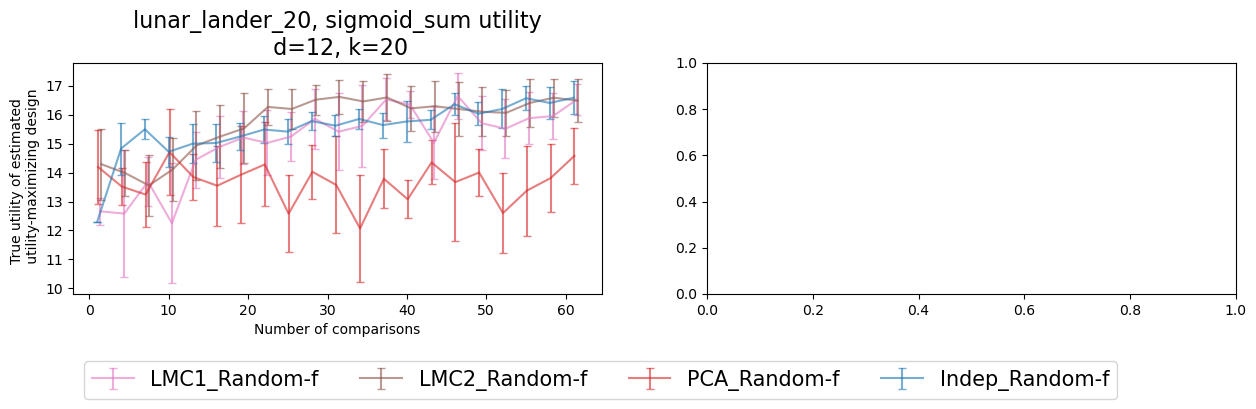

In [13]:
plot_candidate_over_comps(problem_names, ['Random-f'], methods = ['st', 'pca', 'lmc1', 'lmc2'], add_marker=False)

In [ ]:
# configs = ['config_1', 'config_3', 'config_5']
strategy = "$EUBO-\\zeta$"

n_configs = len(configs)

result_dict_mean = defaultdict(list)
result_dict_sem = defaultdict(list)

# f, axs = plt.subplots(1, n_configs, figsize=(20, 4))

x_jitter_dict = {"pca": 0.01, "st": 0, "random_linear_proj": 0.005, "random_subset": 3, "mtgp": 0.015, "random_subset": 0.02, "lmc": 0.015}
labels = {
    "pca" + "_" + strategy: "PCA" + "_" + strategy,
    "st" + "_" + strategy: "Indep" + "_" + strategy,
    "random_linear_proj" + "_" + strategy: "Rand-linear-proj" + "_" + strategy,
    "mtgp" + "_" + strategy: "MTGP" + "_" + strategy,
    "random_subset" + "_" + strategy: "Rand-subset" + "_" + strategy,
}
colors_dict = {
    "pca": "tab:red", 
    "st": "tab:blue", 
    "random_linear_proj": "tab:green", 
    "random_subset": "tab:orange", 
    "mtgp": "tab:purple", 
    "lmc": "tab:pink"}
labels_dict = {
    "pca": "PCA", 
    "st": "Indep", 
    "random_linear_proj": "Rand-linear-proj", 
    "random_subset": "Rand-subset", 
    "mtgp": "MTGP",
    "lmc": "LMC"}

for i in range(n_configs):

    config = configs[i]

    every_n_comps = test_configs[config]["every_n_comps"]
    n_check_post_mean = test_configs[config]["n_check_post_mean"]
    outcome_dim = test_configs[config]["outcome_dim"]
    latent_dim = test_configs[config]["latent_dim"]

    means = defaultdict(list)

    for alpha in ALPHAS:
        config_alpha_str = config + "_" + str(alpha)

        exp_candidate_results = [
            res for j in range(NUM_TRIALS) for res in outputs[config_alpha_str][j]["exp_candidate_results"]
        ]


        exp_candidate_results_random = []
        exp_candidate_results_nonrandom = []

        for res in exp_candidate_results:

            if res["strategy"] == "Random Experiment":
                exp_candidate_results_random.append(res)
            else:
                exp_candidate_results_nonrandom.append(res)

    # Prepare the 2nd experimentation batch data for plot
    exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
    exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
    exp_df["strategy"] = pd.Categorical(
        # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
        exp_df["strategy"],
        ["True Utility", "$EUBO-\zeta$", "Random-f"],
    )
    exp_df = (
        exp_df.groupby(["method", "strategy"])
        .agg({"time_consumed": ["mean", "sem"]})
        .droplevel(level=0, axis=1)
        .reset_index()
    )

    for name, group in exp_df.groupby(["method", "strategy"]):

        method = name[0]

        # jitter = x_jitter_dict[method]
        # alpha_jittered = alpha + jitter

        if name[1] == strategy:

            result_dict_mean[method].append(group["mean"].values[0])
            result_dict_sem[method].append(1.96 * group["sem"].values[0])

            # axs[i].errorbar(
            #     x=[alpha_jittered],
            #     y=group["mean"],
            #     yerr=1.96 * group["sem"],
            #     fmt=marker_dict[name[1]],
            #     markersize=10,
            #     label=labels[name[0] + "_" + name[1]],
            #     linewidth=1.5,
            #     capsize=5,
            #     color=colors_dict[name[0]],
            #     # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
            # )

            # means[method].append(group["mean"].values[0])

        # labels[name[0] + "_" + name[1]] = "_nolegend_"
    

for method in result_dict_mean.keys():
    plt.errorbar(
        [10,30,50],
        result_dict_mean[method],
        result_dict_sem[method],
        markersize=10,
        label=labels_dict[method],
        linewidth=3,
        capsize=5,
        color=colors_dict[method],
    )

# axs[0].legend(bbox_to_anchor=(0, -0.32), loc="lower left", ncol=5, fontsize=12)
plt.ylabel("BOPE runtime (s)", fontsize = 25)
plt.xlabel(r'Outcome dimensionality $k$', fontsize = 25)
legend = plt.legend(fontsize=14)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.1))
legend.get_frame().set_edgecolor((1, 1, 1, 0.1))
# plt.ylim([0,750])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# plt.savefig(f'bope_runtime.pdf', bbox_inches = "tight")

In [200]:
all_results = defaultdict(list)

for problem_name in problem_names:

    pca_results_eubo = []
    pca_results_randomf = []

    for i in range(NUM_TRIALS):
        res = outputs[problem_name][i]["exp_candidate_results"]
        for d in res:
            if d["strategy"] == "Random Experiment":
                break
            if d["method"] == "pca":
                if d["strategy"] == "EUBO-zeta":
                    pca_results_eubo.append(d)

                else:
                    pca_results_randomf.append(d)

    all_results[(problem_name, "eubo")] = pca_results_eubo
    all_results[(problem_name, "randomf")] = pca_results_randomf

Text(0, 0.5, 'final candidate utility')

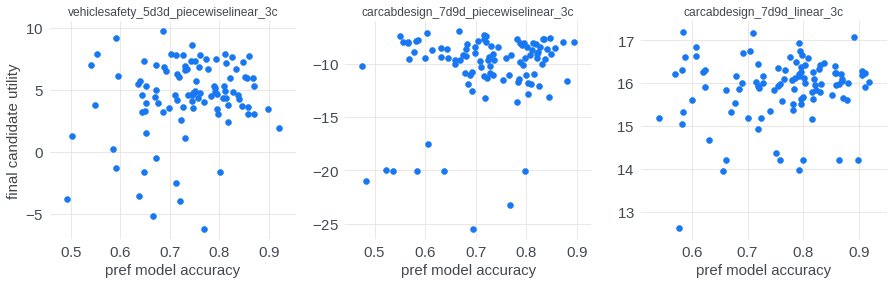

In [201]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['pref_model_acc'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('pref model accuracy')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'pref model accuracy')

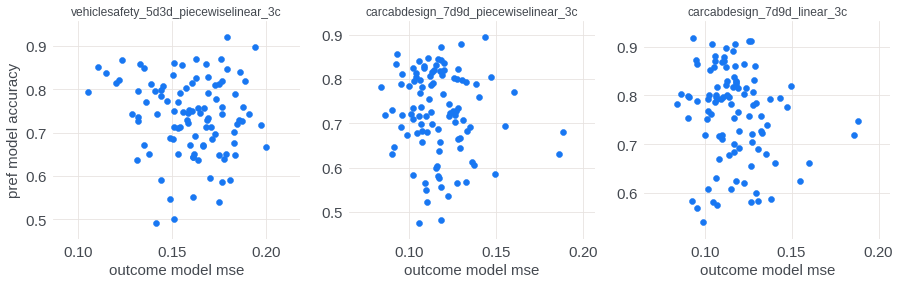

In [203]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df["outcome_model_mse"], pca_results_df["pref_model_acc"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel("outcome model mse")

axs[0].set_ylabel("pref model accuracy")

Text(0, 0.5, 'pref model accuracy')

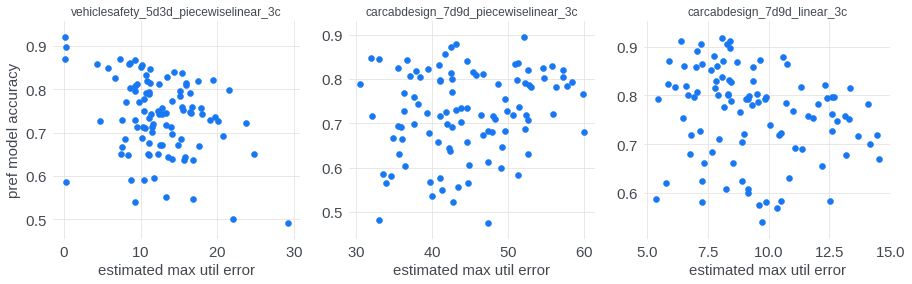

In [204]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['mc_max_util_error'], pca_results_df["pref_model_acc"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('estimated max util error')

axs[0].set_ylabel("pref model accuracy")


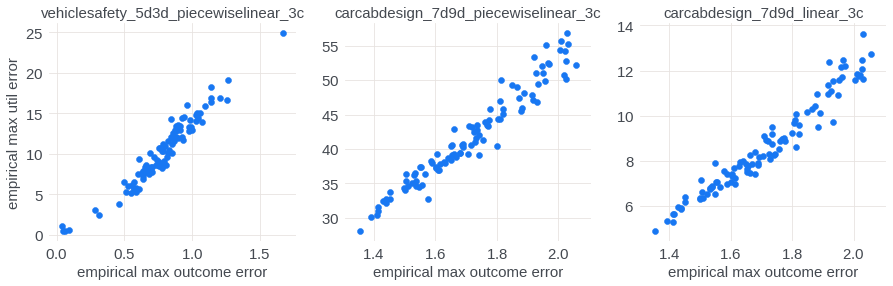

In [209]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_outcome_error'], pca_results_df["empirical_max_util_error"])
    axs[j].set_title(problem, fontsize=15)
    axs[j].set_xlabel('empirical max outcome error')

axs[0].set_ylabel("empirical max util error")

plt.savefig(f'BOPE_real_outcome_vs_util_error.pdf', bbox_inches = "tight")

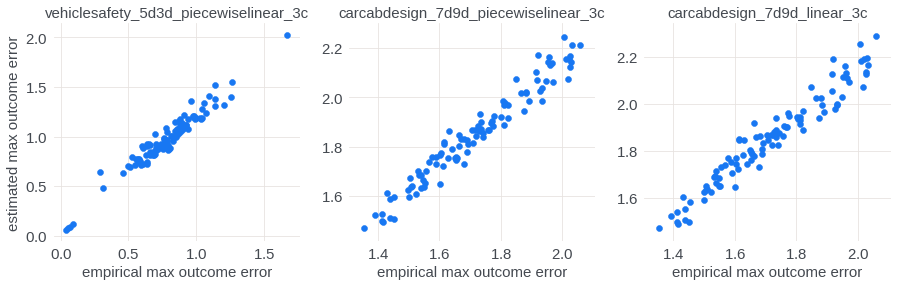

In [210]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_outcome_error'], pca_results_df["mc_max_outcome_error"])
    axs[j].set_title(problem, fontsize=15)
    axs[j].set_xlabel('empirical max outcome error')

axs[0].set_ylabel("estimated max outcome error")

plt.savefig(f'BOPE_real_outcome_error.pdf', bbox_inches = "tight")

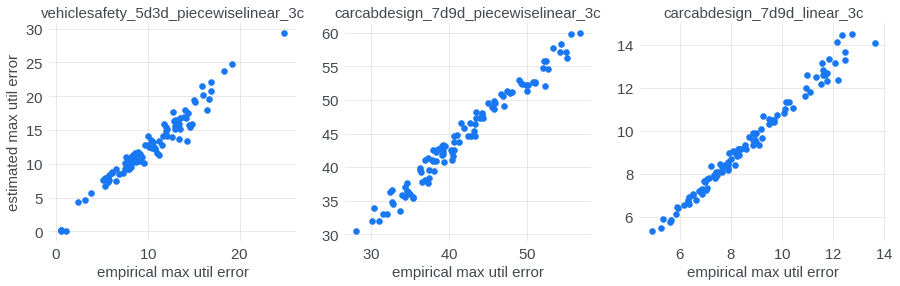

In [211]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_util_error'], pca_results_df["mc_max_util_error"])
    axs[j].set_title(problem, fontsize=15)
    axs[j].set_xlabel('empirical max util error')

axs[0].set_ylabel("estimated max util error")

plt.savefig(f'BOPE_real_util_error.pdf', bbox_inches = "tight")

Text(0, 0.5, 'final candidate utility')

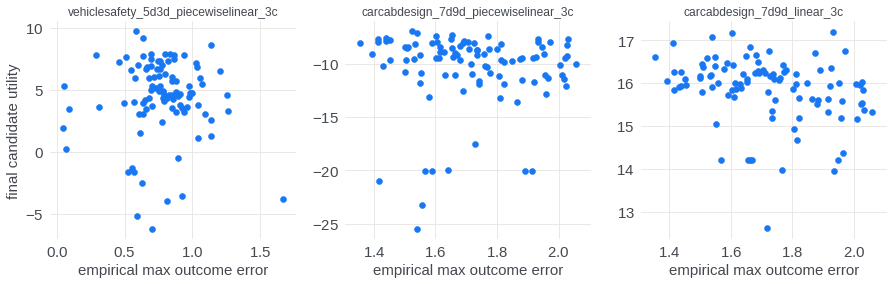

In [206]:
f, axs = plt.subplots(1, 3, figsize=(15,4))

for j in range(3):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_outcome_error'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('empirical max outcome error')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'final candidate utility')

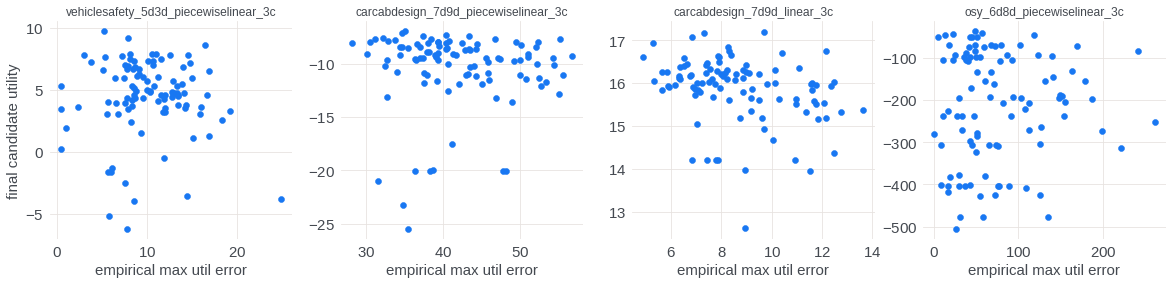

In [142]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))

for j in range(4):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['empirical_max_util_error'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('empirical max util error')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'final candidate utility')

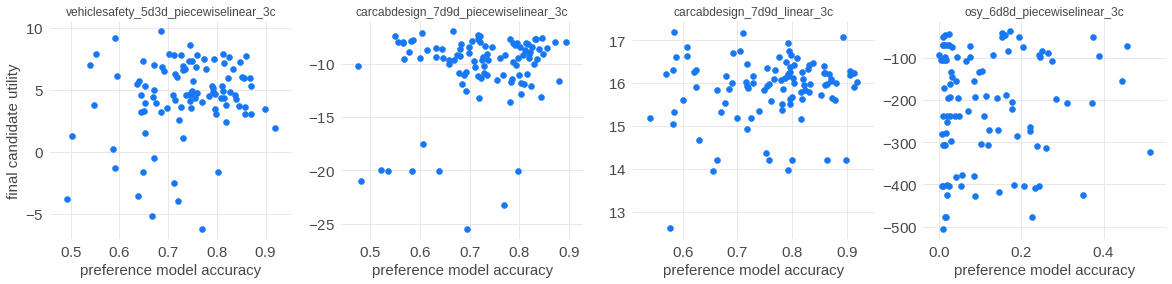

In [143]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))

for j in range(4):
    problem = problem_names[j]
    pca_results_df = pd.DataFrame(all_results[(problem, "eubo")])
    # print(pca_results_df.columns)
    axs[j].scatter(pca_results_df['pref_model_acc'], pca_results_df["candidate_util"])
    axs[j].set_title(problem, fontsize=12)
    axs[j].set_xlabel('preference model accuracy')

axs[0].set_ylabel("final candidate utility")


Text(0, 0.5, 'estimated max util error')

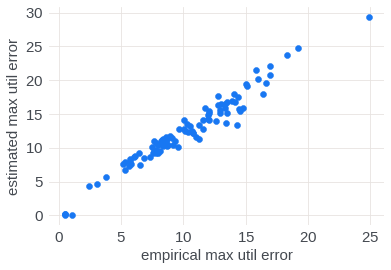

In [108]:
plt.scatter(pca_results_eubo_df['empirical_max_util_error'], pca_results_eubo_df['mc_max_util_error'])
plt.xlabel('empirical max util error')
plt.ylabel('estimated max util error')

Text(0, 0.5, 'estimated max outcome error')

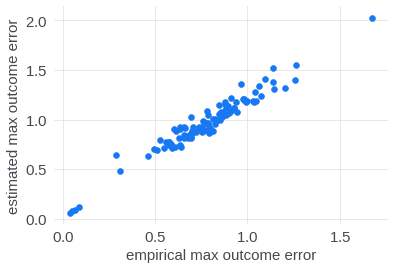

In [109]:
plt.scatter(pca_results_eubo_df['empirical_max_outcome_error'], pca_results_eubo_df['mc_max_outcome_error'])
plt.xlabel('empirical max outcome error')
plt.ylabel('estimated max outcome error')

Text(0, 0.5, 'final candidate utility')

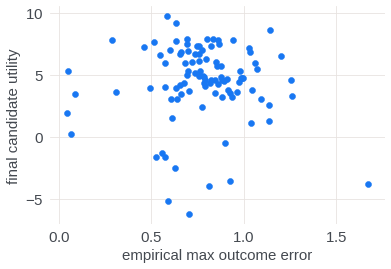

In [113]:
plt.scatter(pca_results_eubo_df["empirical_max_outcome_error"], pca_results_eubo_df["candidate_util"])
plt.xlabel("empirical max outcome error")
plt.ylabel("final candidate utility")

In [104]:
# what does the outcome distribution of OSY look like?

# below not relevant for now

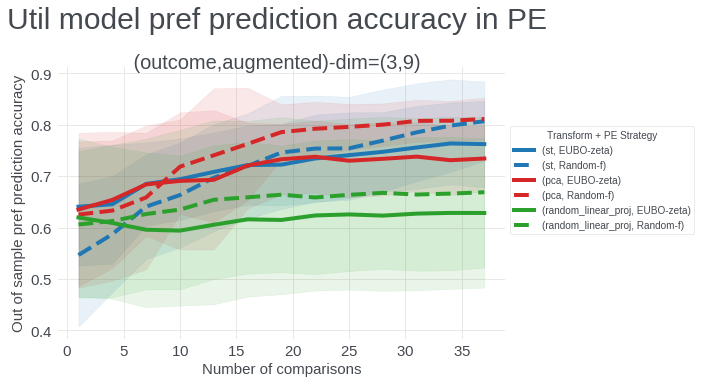

In [139]:
plt.figure(figsize=(8, 5))
for method_pe_strategy_tuple in model_accs_avg.keys():
    method, pe_strategy = method_pe_strategy_tuple
    plt.plot(
        [1 + 3 * i for i in range(13)],
        model_accs_avg[method_pe_strategy_tuple][0],  # mean
        label=f"({method}, {pe_strategy})",
        color=colors_dict[method],
        linestyle=linestyle_dict[pe_strategy],
    )
    plt.fill_between(
        [1 + 3 * i for i in range(13)],
        model_accs_avg[method_pe_strategy_tuple][0] - model_accs_avg[method_pe_strategy_tuple][1],
        model_accs_avg[method_pe_strategy_tuple][0] + model_accs_avg[method_pe_strategy_tuple][1],
        color=colors_dict[method],
        alpha=0.1,
    )
plt.legend()
plt.title("Util model pref prediction accuracy in PE \n")
plt.suptitle(f"\n (outcome,augmented)-dim=({outcome_dim},{augmented_dim})", fontsize=20)

plt.xlabel("Number of comparisons")
plt.ylabel("Out of sample pref prediction accuracy")
plt.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))


plt.savefig(f"PE_util_model_acc_{outcome_dim}_{augmented_dim}.pdf", bbox_inches="tight")

In [140]:

exp_candidate_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]['exp_candidate_results']]


exp_candidate_results_random = []
exp_candidate_results_nonrandom = []


for res in exp_candidate_results:
    if res['strategy'] == 'Random Experiment':
        exp_candidate_results_random.append(res)
    else:
        exp_candidate_results_nonrandom.append(res)


In [141]:
len(exp_candidate_results)

1000

In [142]:

# Prepare the 2nd experimentation batch data for plot
exp_df = pd.DataFrame(exp_candidate_results_nonrandom)
exp_df["strategy"] = exp_df["strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
exp_df["strategy"] = pd.Categorical(
    # exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f", "Random Experiment"]
    exp_df["strategy"], ["True Utility", "$EUBO-\zeta$", "Random-f"]
)
exp_df = exp_df.groupby(["method","strategy"]).agg({"candidate_util": ["mean", "sem"]}).droplevel(level=0, axis=1).reset_index()


exp_df_random = pd.DataFrame(exp_candidate_results_random)
exp_df_random = exp_df_random.groupby(["strategy"]).agg({"candidate_util": ["mean", "sem"]}).droplevel(level=0, axis=1).reset_index()

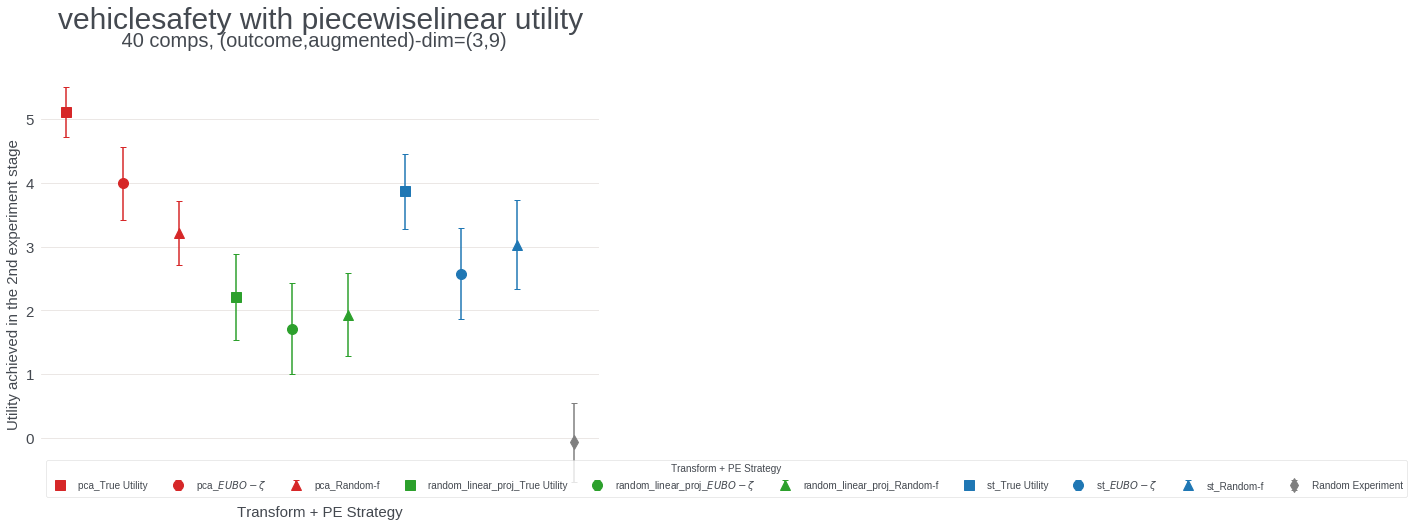

In [152]:
# Plotting
plt.figure(figsize=(10, 8))

# fig, ax = plt.subplots()


for name, group in exp_df.groupby(["method", "strategy"], sort=True):

    plt.errorbar(
        x=[group["method"].values[0] + "_" + group["strategy"].values[0]],
        y=group["mean"],
        yerr=1.96 * group["sem"],
        fmt=marker_dict[name[1]],
        markersize=10,
        label="_".join(name),
        linewidth=1.5,
        capsize=3,
        color=colors_dict[name[0]],
        # transform = ax.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
    )

# TODO: plot random experiment result
plt.errorbar(
    x=exp_df_random["strategy"],
    y=exp_df_random["mean"],
    yerr=1.96 * exp_df_random["sem"],
    fmt="d",
    markersize=10,
    label="Random Experiment",
    linewidth=1.5,
    capsize=3,
    color="tab:grey",
)

plt.xlabel("Transform + PE Strategy")
plt.ylabel("Utility achieved in the 2nd experiment stage")
plt.legend(title="Transform + PE Strategy", loc = 'lower left', ncol = 10)
plt.title(f"{problem_name} with {util_func_name} utility\n")
plt.suptitle(
    f"\n {1 + every_n_comps * n_check_post_mean} comps, (outcome,augmented)-dim=({outcome_dim},{augmented_dim})",
    fontsize=20,
)


plt.xticks(rotation=90)
plt.xticks([])


plt.savefig(f"final_candidate_utility_{outcome_dim}_{augmented_dim}.pdf", bbox_inches="tight")

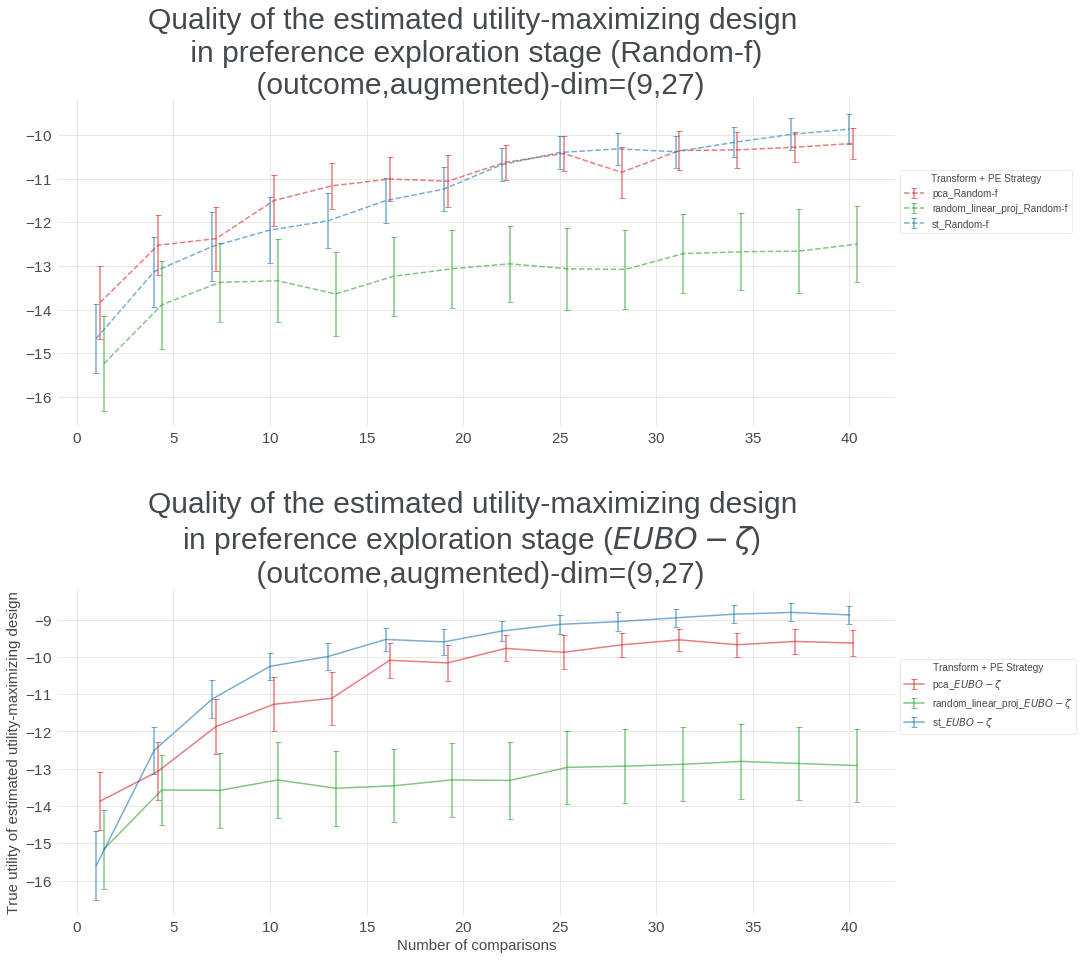

In [124]:
within_session_results = [res for i in range(NUM_TRIALS) for res in outputs[problem][i]["within_session_results"]]


within_df = pd.DataFrame(within_session_results)

within_df["pe_strategy"] = within_df["pe_strategy"].str.replace("EUBO-zeta", r"$EUBO-\\zeta$")
within_df = (
    within_df.groupby(["n_comps", "method", "pe_strategy"])
    .agg({"util": ["mean", "sem"]})
    .droplevel(level=0, axis=1)
    .reset_index()
)

colors_dict = {"pca": "tab:red", "st": "tab:blue", "random_linear_proj": "tab:green", "random_subset": "tab_orange"}

x_jitter_dict = {"pca": 0.2, "st": 0, "random_linear_proj": 0.4, "random_subset": 3}

# Plotting
# plt.figure(figsize=(10, 10))
f, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

for name, group in within_df.groupby(["method", "pe_strategy"], sort=True):
    if name[1] == "Random-f":
        linestyle = "--"

        jitter = x_jitter_dict[group["method"].values[0]]
        x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

        ax1.errorbar(
            x=x_jittered,
            y=group["mean"].values,
            yerr=1.96 * group["sem"],
            label="_".join(name),
            linewidth=1.5,
            capsize=3,
            alpha=0.6,
            linestyle=linestyle,
            color=colors_dict[name[0]],
        )

        ax1.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))
    else:
        linestyle = "-"

        jitter = x_jitter_dict[group["method"].values[0]]
        x_jittered = [x_ + jitter for x_ in group["n_comps"].values]

        ax2.errorbar(
            x=x_jittered,
            y=group["mean"],
            yerr=1.96 * group["sem"],
            label="_".join(name),
            linewidth=1.5,
            capsize=3,
            alpha=0.6,
            linestyle=linestyle,
            color=colors_dict[name[0]],
        )

        ax2.legend(title="Transform + PE Strategy", bbox_to_anchor=(1, 0.8))


plt.xlabel("Number of comparisons")
plt.ylabel("True utility of estimated utility-maximizing design")
ax2.set_title(
    "Quality of the estimated utility-maximizing design \n"
    + r"in preference exploration stage ($EUBO-\zeta$)  "
    + f"\n (outcome,augmented)-dim=({outcome_dim},{augmented_dim})"
)
ax1.set_title(
    "Quality of the estimated utility-maximizing design \n in preference exploration stage (Random-f) "
    + f"\n (outcome,augmented)-dim=({outcome_dim},{augmented_dim})"
)


plt.savefig(f"PE_candidates_quality_{outcome_dim}_{augmented_dim}.pdf", bbox_inches="tight")

In [75]:
import torch
b = torch.Tensor([[0, 1]] * 3)

In [76]:
b

tensor([[0., 1.],
        [0., 1.],
        [0., 1.]])

In [81]:
list(map(tuple, b.numpy()))

[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [82]:
b

tensor([[0., 1.],
        [0., 1.],
        [0., 1.]])

In [83]:
b.mean(dim = 1)

tensor([0.5000, 0.5000, 0.5000])

In [84]:
b * (-1)

tensor([[-0., -1.],
        [-0., -1.],
        [-0., -1.]])